In [3]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print(torch.__version__)

2.1.0+cu121


### Get the Food101 dataset from PyTorch.

- Food101 in `torchvision.datasets` - https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html
- Original Food101 dataset - https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

*Note: Downloading the dataset from PyTorch may take ~10-15 minutes depending on your internet speed. It will download ~5GB of data to the specified `root` directory.*


In [4]:
# Setup data directory
import pathlib
data_dir = pathlib.Path("../data")

# Get training data
train_data = datasets.Food101(root = data_dir,
                              split = "train",
                              # transform=transforms.ToTensor(),
                              download = True)

# Get testing data
test_data = datasets.Food101(root = data_dir,
                             split = "test",
                             # transform=transforms.ToTensor(),
                             download = True)

100%|██████████| 4996278331/4996278331 [06:31<00:00, 12757638.23it/s]


Extracting ../data/food-101.tar.gz to ../data


In [5]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: ../data
    split=train

In [6]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

churros


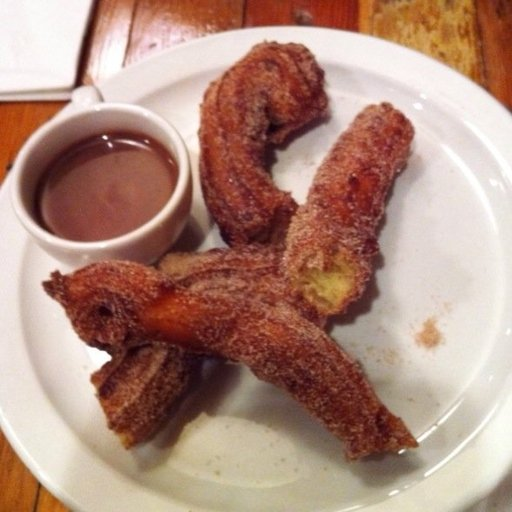

In [7]:
# View first sample (PIL Image format)
print(class_names[train_data[0][1]])
train_data[0][0]

### Find subset of appropriate classes

Want: Steak, pizza, sushi.

Current path setup:

    ../data/food-101/images/CLASS_NAME/IMAGES.jpg

Going to get a list of the different target image classes (`pizza`, `steak`, `sushi`) filenames and then copy the images to separate folders.

I'd like to get a random 30% of the images from the target classes from both datasets.

In [8]:
# Get random 10% of training images
import random

# Setup data paths
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "steak", "sushi"]

# Change amount of data to get (e.g. 0.2 = random 20%)
amount_to_get = 0.3

# Create function to separate a random amount of data
def get_subset(image_path = data_path,
               data_splits = ["train", "test"],
               target_classes = ["pizza", "steak", "sushi"],
               amount = 0.1,
               seed = 42):
    random.seed(42)
    label_splits = {}

    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)

        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]


[INFO] Creating image split for: train...
[INFO] Getting random subset of 675 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 225 images for test...


[PosixPath('../data/food-101/images/pizza/3269634.jpg'),
 PosixPath('../data/food-101/images/pizza/1524655.jpg'),
 PosixPath('../data/food-101/images/steak/2825100.jpg'),
 PosixPath('../data/food-101/images/steak/225990.jpg'),
 PosixPath('../data/food-101/images/steak/1839481.jpg'),
 PosixPath('../data/food-101/images/pizza/38349.jpg'),
 PosixPath('../data/food-101/images/pizza/3018077.jpg'),
 PosixPath('../data/food-101/images/sushi/93139.jpg'),
 PosixPath('../data/food-101/images/pizza/2702825.jpg'),
 PosixPath('../data/food-101/images/sushi/200025.jpg')]

In [9]:
### Create target directory path
target_dir_name = f"../data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../data/pizza_steak_sushi_30_percent'


In [11]:
import shutil
from tqdm import tqdm

for image_split in tqdm(label_splits.keys(), desc="Processing Splits"):
    for image_path in tqdm(label_splits[str(image_split)], desc=f"Copying images for {image_split}"):
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        # print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

Processing Splits: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]


### Zip up images folder to be more easily transported

In [12]:
# Zip pizza_steak_sushi images
zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
shutil.make_archive(zip_file_name,
                    format="zip",
                    root_dir=target_dir)


'/data/pizza_steak_sushi_30_percent.zip'

In [13]:
!ls -la ../data/

total 4925280
drwxr-xr-x 4 root root       4096 Feb  1 14:58 .
drwxr-xr-x 1 root root       4096 Feb  1 14:48 ..
drwxr-xr-x 4 3156  320       4096 Jul  9  2014 food-101
-rw-r--r-- 1 root root 4996278331 Feb  1 14:55 food-101.tar.gz
drwxr-xr-x 4 root root       4096 Feb  1 14:57 pizza_steak_sushi_30_percent
-rw-r--r-- 1 root root   47184848 Feb  1 14:58 pizza_steak_sushi_30_percent.zip


In [1]:
!mkdir -p pizza_steak_sushi
!unzip ../data/pizza_steak_sushi_30_percent.zip -d pizza_steak_sushi

unzip:  cannot find or open ../data/pizza_steak_sushi_30_percent.zip, ../data/pizza_steak_sushi_30_percent.zip.zip or ../data/pizza_steak_sushi_30_percent.zip.ZIP.


In [15]:
!ls ../data

food-101  food-101.tar.gz  pizza_steak_sushi_30_percent  pizza_steak_sushi_30_percent.zip


In [19]:
# Check lengths of directories
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  import os
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [20]:
walk_through_dir("pizza_steak_sushi")

There are 2 directories and 0 images in 'pizza_steak_sushi'.
There are 3 directories and 0 images in 'pizza_steak_sushi/test'.
There are 0 directories and 84 images in 'pizza_steak_sushi/test/steak'.
There are 0 directories and 70 images in 'pizza_steak_sushi/test/pizza'.
There are 0 directories and 71 images in 'pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'pizza_steak_sushi/train'.
There are 0 directories and 226 images in 'pizza_steak_sushi/train/steak'.
There are 0 directories and 221 images in 'pizza_steak_sushi/train/pizza'.
There are 0 directories and 228 images in 'pizza_steak_sushi/train/sushi'.


In [21]:
!ls

pizza_steak_sushi  sample_data


### Let's download subset sample of pizza_steak_sushi

In [26]:
from tqdm import tqdm
import zipfile
import os

# Define the source folder and zip file path
source_folder = '/content/pizza_steak_sushi'
zip_file_path = '/content/pizza_steak_sushi.zip'

# Create a zip file with a progress bar
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, _, files in tqdm(os.walk(source_folder), desc="Zipping files"):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, source_folder)
            zipf.write(file_path, arcname)

# Display a message after completion
print(f"Zip file created at: {zip_file_path}")

Zipping files: 9it [00:00, 31.06it/s]

Zip file created at: /content/pizza_steak_sushi.zip


In [24]:
# Local Download
from google.colab import files
files.download("/content/pizza_steak_sushi.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>